# This is to explore Boston Housing prices using linear regression and neural networks.

In [1]:
from keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.boston_housing.load_data()

Using TensorFlow backend.
/home/raymond/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raymond/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raymond/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/raymond/anaconda3/lib/python3.7/site-packages/t

 Variables in order:
 
 **CRIM**     per capita crime rate by town
 
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 
 INDUS    proportion of non-retail business acres per town
 
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 
 NOX      nitric oxides concentration (parts per 10 million)
 
 RM       average number of rooms per dwelling
 
 AGE      proportion of owner-occupied units built prior to 1940
 
 DIS      weighted distances to five Boston employment centres
 
 RAD      index of accessibility to radial highways
 
 TAX      full-value property-tax rate per $10,000
 
 PTRATIO  pupil-teacher ratio by town
 
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 
 LSTAT    \% lower status of the population
 
 MEDV     Median value of owner-occupied homes in $1000's

In [2]:
featureNames = ['CRIME', 'ZONES', 'INDUSTRY', 'CHARLES', 'NITRIC OXIDES', 'ROOMS', 'AGE', 'DISTANCE TO EMPLOYMENT', 
                'RADIAL_HIGHWAYS', 'TAX BY $10,000', 'PUPIL/TEACHER RATIO', 'BK PROPORTION', 'LOWER STATUS %' ]
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)

x_train shape:  (404, 13)
y_train shape:  (404,)


## Apply linear regression for every individual feature. 

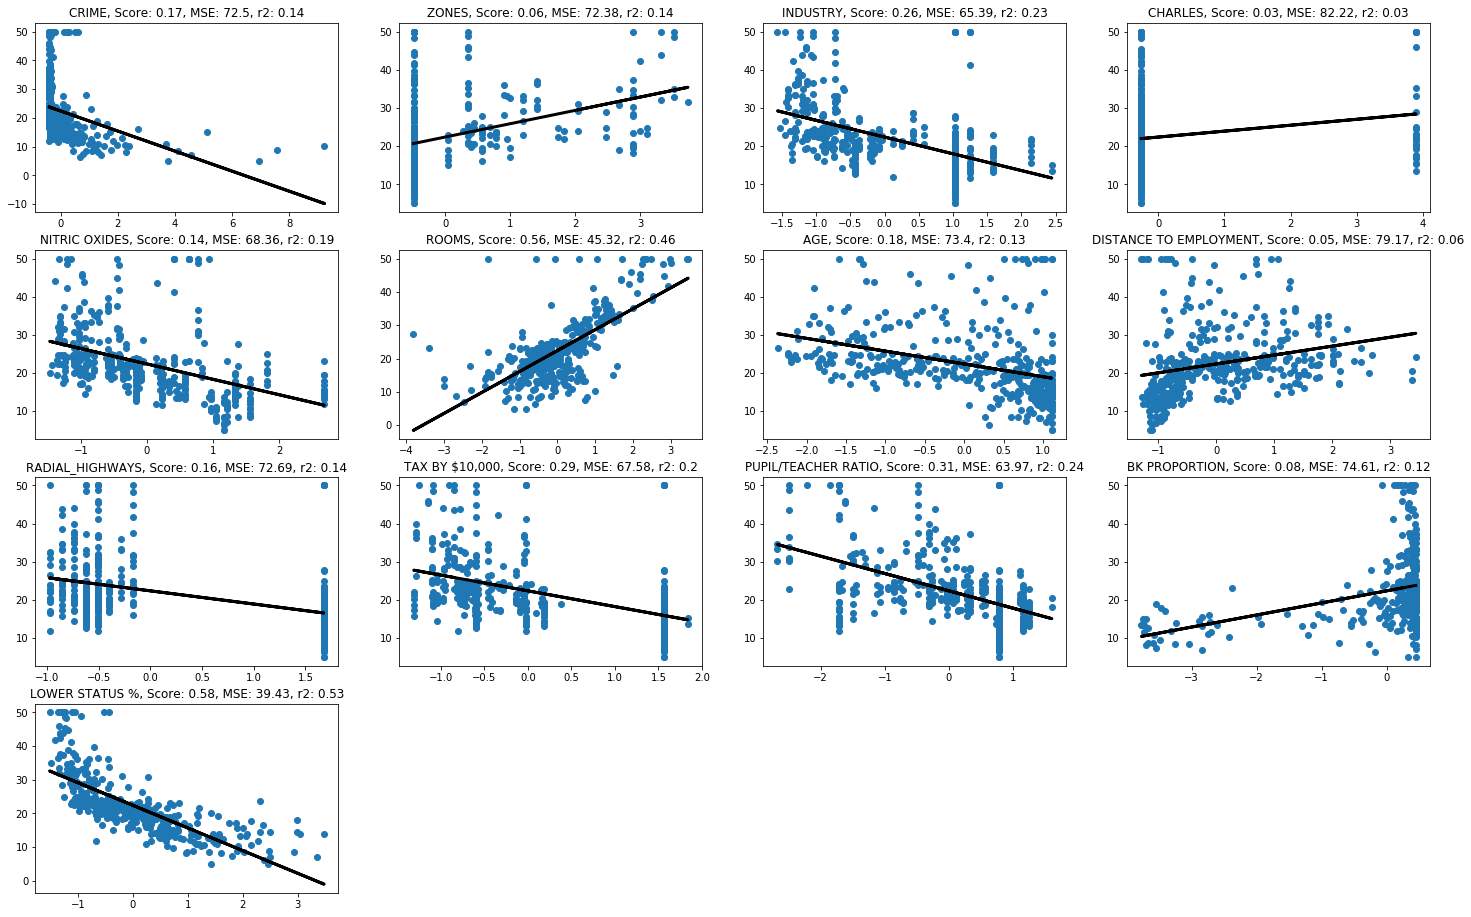

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


plt.figure(figsize=(25,16))
for i in range(len(x_train[0])):
    plt.subplot(4,4, i+1)
    array = x_train[:,i].reshape(404,1)
    label=y_train.reshape(404,1)
    model = LinearRegression().fit(array, label)
    score = model.score(x_test[:,i].reshape(102,1), y_test.reshape(102,1))    
    mse = mean_squared_error(label, model.predict(array))
    r2 = r2_score(label, model.predict(array))
    plt.scatter(array, y_train.reshape(404,1))
    plt.plot(array, model.predict(array.reshape(404,1)), color = 'black', linewidth=3)
    plt.title("{0}, Score: {1}, MSE: {2}, r2: {3}".format(featureNames[i], round(score,2), round(mse,2), round(r2,2)))
plt.show()

## Create Correlation Matrix

This will allow us to understand which features have more impact on the home values

In [4]:
import numpy as np
import pandas as pd
combinedArray = np.hstack((x_train,y_train.reshape(404,1)))
df = pd.DataFrame(combinedArray)

In [5]:
df = df.rename(columns={0:'CRIME', 1:'ZONES', 2:'INDUSTRY', 3:'CHARLES', 4:'NITRIC OXIDES', 5:'ROOMS', 6:'AGE', 7:'DISTANCE TO EMPLOYMENT', 
                8:'RADIAL_HIGHWAYS', 9:'TAX BY $10,000', 10:'PUPIL/TEACHER RATIO', 11:'BK PROPORTION', 12:'LOWER STATUS %', 13:'MEDIAN VALUE'})

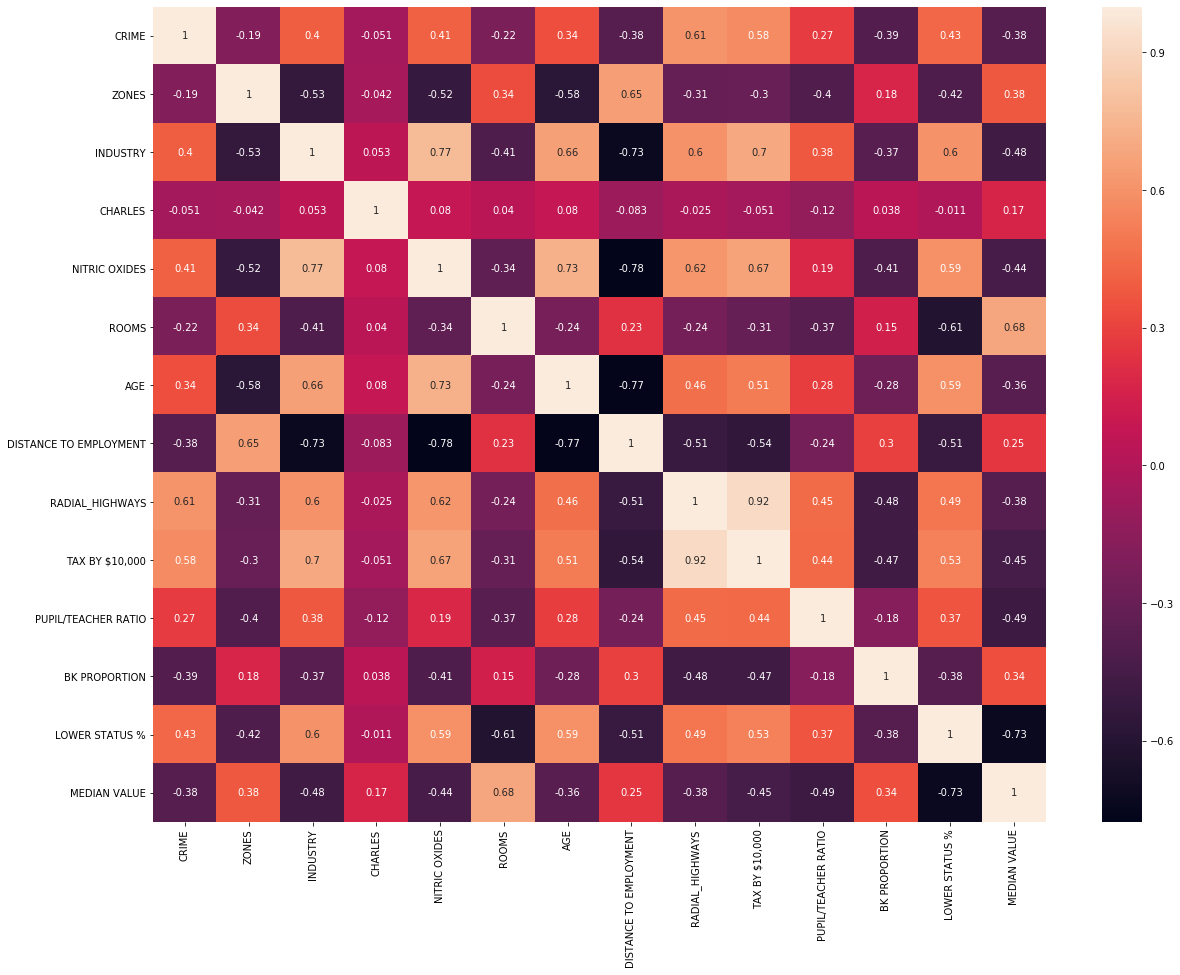

In [6]:
import seaborn as sns
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)

# Results of linear regression

ROOMS has the highest positive correlation score. 
LOWER STATUS % has the highest negative correlation score. 

As you can see on the linear regression slopes and scores for each model, they are in agreement. 

# Neural Network

Here we implement a Neural Network that takes in all features to perform linear regression

Neural Networks work the best when data is normalized. The below cell performs this operation

In [7]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

Create a model.

In [8]:
from keras import models
from keras import layers

def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
    return model


## Use k-fold

Using cross validation allows us to ensure even distribution of data, as well as to lower overfitting. 

In [9]:
k = 4

num_val_samples = len(x_train) // k
num_epoch = 100
all_scores = []

In [10]:
num_epoch = 500
all_mse_histories = []


for i in range(k):
    print('processing fold #', i)
    val_data = x_train[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [x_train[:i * num_val_samples],
    x_train[(i+1) * num_val_samples:]], axis=0)
    
    partial_train_target = np.concatenate(
    [y_train[:i * num_val_samples],
    y_train[(i+1) * num_val_samples:]], axis=0)    
    
    model2 = create_model()
    history = model2.fit(partial_train_data, partial_train_target,
              validation_data = (val_data, val_targets),
             epochs=num_epoch, batch_size=1, verbose=0)
    #val_mse, val_mae = model2.evaluate(val_data, val_targets, verbose=0)
    mae_history = history.history['val_mse']
    all_mse_histories.append(mae_history)

    

processing fold # 0

processing fold # 1
processing fold # 2
processing fold # 3


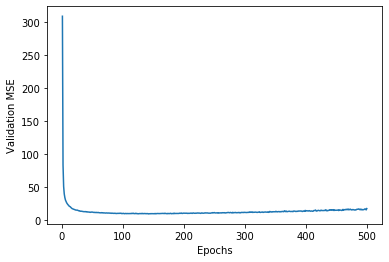

In [11]:
average_mse_history = [np.mean([x[i] for x in all_mse_histories]) for i in range(num_epoch)]

plt.plot(range(1, len(average_mse_history) + 1), average_mse_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.show()

## Results

At around 80-100 epochs, the validation MSE seems to be at it's lowest point. 

# Conclusion

Linear Regression works great for it's simplicity, and its easy to explain to others how it works. Simply minimizing the squared distances between the predicted value and actual value is usually sufficient. Therefore a equation is developed, and the need for an abudance of data is not there.

Neural Networks can do the same as well, but it tends to be a bit complex. It requires a lot of data, and for something that can be nonlinear, neural networks might be a better choice. Compute power can be intensive as well.